In [11]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
EMBEDDING_DIM = 100
MAX_LENGTH = 32
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

In [3]:
data_path = "./data.csv"
df = pd.read_csv(data_path, encoding='latin-1')
df.head()

,Description,Category,Sub_Category
0,Arby's,Food,FastFood_Restaurants
1,Burger King,Food,FastFood_Restaurants
2,Carl's Jr.,Food,FastFood_Restaurants
3,Chick-fil-A,Food,FastFood_Restaurants
4,Chipotle Mexican Grill,Food,FastFood_Restaurants


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Description'])

In [5]:
def augment_text(text):
    tokens = text.split()
    if len(tokens) > 1:
        tf.random.shuffle(tokens)
    return ' '.join(tokens)

In [6]:
augmented_texts = []
for text in df['Description']:
    augmented_texts.append(augment_text(text))

In [7]:
augmented_data = pd.DataFrame({
    'description': list(df['Description']) + augmented_texts,
    'category': list(df['Category']) * 2
})

In [8]:
augmented_data = shuffle(augmented_data).reset_index(drop=True)
data = augmented_data

In [9]:
print(data)

                                            description     category
0                                            LG Stylo 6  Electronics
1                                          Google Fiber    Utilities
2                                           Whataburger         Food
3          Mophie Powerstation Plus XL Portable Charger  Electronics
4                                 Fairmont Copley Plaza     Vacation
...                                                 ...          ...
6935                                  New Balance 990v3      Clothes
6936                             Apple iPhone SE (2020)  Electronics
6937                                    Fila Ray Tracer      Clothes
6938  Simple Joys by Carter's Baby Girls' 6-Pack Sho...      Clothes
6939  Continental Elite Timing Belt Kit with Water Pump         Auto

[6940 rows x 2 columns]


In [12]:
label_encoder = LabelEncoder()

data['Label_Encoded'] = label_encoder.fit_transform(data['category'])

print(data)

                                            description     category  \
0                                            LG Stylo 6  Electronics   
1                                          Google Fiber    Utilities   
2                                           Whataburger         Food   
3          Mophie Powerstation Plus XL Portable Charger  Electronics   
4                                 Fairmont Copley Plaza     Vacation   
...                                                 ...          ...   
6935                                  New Balance 990v3      Clothes   
6936                             Apple iPhone SE (2020)  Electronics   
6937                                    Fila Ray Tracer      Clothes   
6938  Simple Joys by Carter's Baby Girls' 6-Pack Sho...      Clothes   
6939  Continental Elite Timing Belt Kit with Water Pump         Auto   

      Label_Encoded  
0                 3  
1                13  
2                 5  
3                 3  
4                14  
...

In [13]:
labels = data['Label_Encoded'].to_numpy()
sentences = data['description'].to_numpy()

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

# Get the first 5 elements of the dataset
examples = list(dataset.take(5))

print(f"dataset contains {len(dataset)} examples\n")

print(f"Text of second example look like this: {examples[1][0].numpy().decode('utf-8')}\n")
print(f"Labels of first 5 examples look like this: {[x[1].numpy() for x in examples]}")

dataset contains 6940 examples

Text of second example look like this: Google Fiber

Labels of first 5 examples look like this: [3, 13, 5, 3, 14]


In [14]:
def train_val_datasets(dataset):
    train_size = int(len(dataset) * TRAINING_SPLIT)

    # Split the sentences and labels into train/validation splits
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size)

    # Turn the dataset into a batched dataset with num_batches batches
    train_dataset = train_dataset.batch(NUM_BATCHES)
    validation_dataset = validation_dataset.batch(NUM_BATCHES)

    return train_dataset, validation_dataset

In [15]:
# Create the train and validation datasets
train_dataset, validation_dataset = train_val_datasets(dataset)

print(f"There are {len(train_dataset)} batches for a total of {NUM_BATCHES*len(train_dataset)} elements for training.\n")
print(f"There are {len(validation_dataset)} batches for a total of {NUM_BATCHES*len(validation_dataset)} elements for validation.\n")

There are 49 batches for a total of 6272 elements for training.

There are 6 batches for a total of 768 elements for validation.



In [17]:
def fit_vectorizer(dataset):
    vectorizer = tf.keras.layers.TextVectorization(
        output_sequence_length=MAX_LENGTH,  # Desired length of output sequences
    )

    # Fit the tokenizer to the training sentences
    vectorizer.adapt(dataset)

    return vectorizer

In [18]:
# Get only the texts out of the dataset
text_only_dataset = train_dataset.map(lambda text, label: text)

# Adapt the vectorizer to the training sentences
vectorizer = fit_vectorizer(text_only_dataset)

# Check size of vocabulary
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 4439 words



In [19]:
# Apply vectorization to train and val datasets
train_dataset_vectorized = train_dataset.map(lambda x,y: (vectorizer(x), y))
validation_dataset_vectorized = validation_dataset.map(lambda x,y: (vectorizer(x), y))

In [20]:
# Define path to file containing the embeddings
glove_file = './glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
glove_embeddings = {}

# Read file and fill glove_embeddings with its contents
with open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

In [22]:
test_word = 'burger'

test_vector = glove_embeddings[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word burger looks like this:

[ 0.33133  -0.27067  -0.13907  -0.088709 -0.043864  0.063834  0.25138
 -0.091424 -0.1784   -0.68607  -0.21564   0.18211  -0.23288   0.34244
  0.18765   0.42714   0.090041 -0.38193  -0.86077   0.10677   0.97605
  0.33179  -0.22349  -0.6037    0.3639    1.1531    0.57479  -0.26689
 -0.2192    0.27449   0.58477   0.72972   0.55298  -0.54246   0.41626
  0.80416   0.016013  0.12076  -0.14406  -1.3187    1.0801    0.072487
 -0.151    -0.84384   0.072104  0.80528  -0.5371   -0.58189   0.2129
  0.19258   0.022321 -0.21964  -0.90854   0.033854 -0.74511  -0.71059
 -0.40855   0.64035   0.1504   -0.036281  0.18085  -0.47587   0.90079
  0.12859   0.16879  -0.47241  -0.49883   0.57205  -0.30949   0.088298
 -0.13453   0.16067   0.26489   0.097569 -0.32744  -0.26541  -0.89286
  0.1455   -0.079116  0.78621   0.23043  -0.48585  -0.066305  0.62033
 -0.3532   -0.80811  -0.42646  -0.6372   -0.51965  -0.29796   0.43657
  0.19157   0.059287 -0.13863  -0.

In [23]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


In [24]:
# Create a word index dictionary
word_index = {x:i for i,x in enumerate(vectorizer.get_vocabulary())}

print(f"The word burger is encoded as: {word_index['burger']}")

The word burger is encoded as: 533


In [25]:
# Initialize an empty numpy array with the appropriate size
embeddings_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the embeddings_matrix array
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [26]:
test_word = 'burger'

test_word_id = word_index[test_word]

test_vector_burger = glove_embeddings[test_word]

test_embedding_burger = embeddings_matrix[test_word_id]

both_equal = np.allclose(test_vector_burger,test_embedding_burger)

print(f"word: {test_word}, index: {test_word_id}\n\nEmbedding is equal to column {test_word_id} in the embeddings_matrix: {both_equal}")

word: burger, index: 533

Embedding is equal to column 533 in the embeddings_matrix: True


In [28]:
def create_model(vocab_size, embedding_dim, embedding_matrix):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size,
                                  embedding_dim,
                                  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                  trainable=False, # Keep the embeddings fixed
                                  mask_zero=True), # Use masking to handle variable sequence lengths
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # Use a bidirectional LSTM for better context understanding
        tf.keras.layers.Dense(64, activation='relu'), # Add a dense layer for feature extraction
        tf.keras.layers.Dense(15, activation='softmax') # Output layer with softmax for multi-class classification
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [29]:
model = create_model(vocab_size, EMBEDDING_DIM, embeddings_matrix)

In [30]:
# Take an example batch of data
example_batch = train_dataset_vectorized.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 15)


In [31]:
# Train the model and save the training history
history = model.fit(
	train_dataset_vectorized,
	epochs=20,
	validation_data=validation_dataset_vectorized
)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 0.3276 - loss: 2.3229 - val_accuracy: 0.6657 - val_loss: 1.1536
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.7103 - loss: 0.9848 - val_accuracy: 0.8141 - val_loss: 0.6413
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.8168 - loss: 0.6041 - val_accuracy: 0.8746 - val_loss: 0.4642
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8726 - loss: 0.4424 - val_accuracy: 0.8991 - val_loss: 0.3734
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.8970 - loss: 0.3542 - val_accuracy: 0.9135 - val_loss: 0.3191
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9157 - loss: 0.2955 - val_accuracy: 0.9251 - val_loss: 0.2687
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9288 - loss: 0.2517 - val_accuracy: 0.9424 - val_loss: 0.2296
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.9362 - loss: 0.2175 - val_accuracy: 

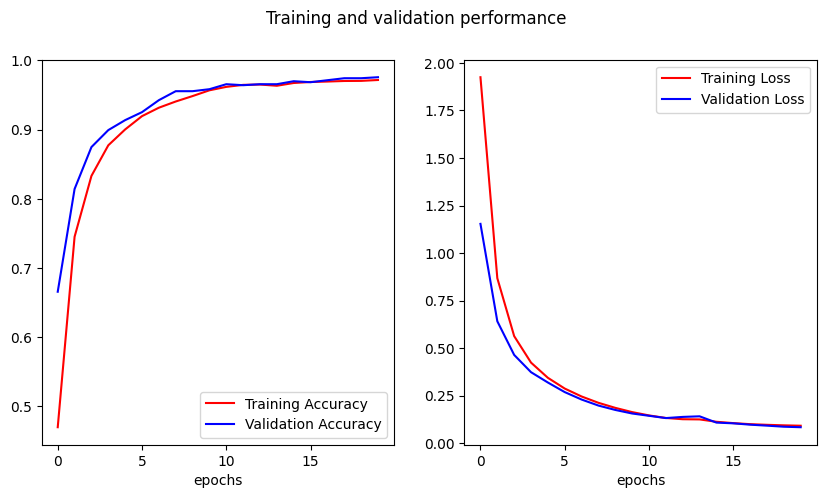

In [32]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')